In [1]:
import sys, os

sys.path.append('/cr/users/filip/bin')

from utils.binaries import *
from utils.plotting import *

from utils.Auger.SD import Monitoring

16:35:01 [INFO] utils          -- ( +3839ms) -- import logging
16:35:01 [INFO] utils.binaries -- (  +149ms) -- import numpy as np
16:35:01 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
16:35:01 [INFO] utils.binaries -- (  +177ms) -- import pandas as pd
16:35:01 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
16:35:02 [INFO] utils.plotting -- (  +304ms) -- import matplotlib.pyplot as plt
16:35:02 [INFO] utils.plotting -- (  +366ms) -- import seaborn as so
16:35:02 [DBUG] utils.plotting -- (    +7ms) -- font size set to 9.5
16:35:02 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
16:35:02 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
16:35:02 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
16:35:02 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
16:35:02 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


# Test format with t1 latch bin

In [ ]:
from datetime import datetime, timedelta

wcd_fmt_no_latch = np.dtype([('timestamp', '<i4'), ('baseline', ('h', 3)), ('trace', ('i2', (3, 2048)))])
ssd_fmt_no_latch = np.dtype([('timestamp', '<i4'), ('baseline', 'h'), ('trace', ('i2', 2048))])

mean_rate = 0
x, y = [],[]

for index in range(801):
    wcd = np.fromfile(f'/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms{index:04}.wcd', dtype=wcd_fmt_no_latch)
    ssd = np.fromfile(f'/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms{index:04}.ssd', dtype=ssd_fmt_no_latch)

    x.append(np.mean(wcd['timestamp']))
    y.append(np.mean(ssd['timestamp']))

In [ ]:
plt.plot(x, y)

# FINAL FORMAT

In [ ]:
wcd_fmt = np.dtype([('timestamp', 'I'), ('t1_latch_bin', 'h'), ('vem_peak', ('H', 3)), ('baseline', ('H', 3)), ('trace', ('h', (3, 2048)))])
ssd_fmt = np.dtype([('timestamp', 'I'), ('t1_latch_bin', 'h'), ('mip_peak', 'H'), ('baseline', 'H'), ('trace', ('h', 2048))])

wcd, ssd = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/temp.wcd', dtype=wcd_fmt), np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/temp.ssd', dtype=ssd_fmt)

In [ ]:
print(len(wcd), len(ssd))

In [ ]:
plt.plot(wcd['timestamp'], ssd['timestamp'])

In [ ]:
len(ssd['trace'][-1])

In [ ]:
print(sum(ssd['t1_latch_bin'] != -1))
print(sum(wcd['t1_latch_bin'] != -1))

In [ ]:
t, t1, vem, baseline, traces = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/temp.wcd')

Text(0, 0.5, 'SSD / ADC')

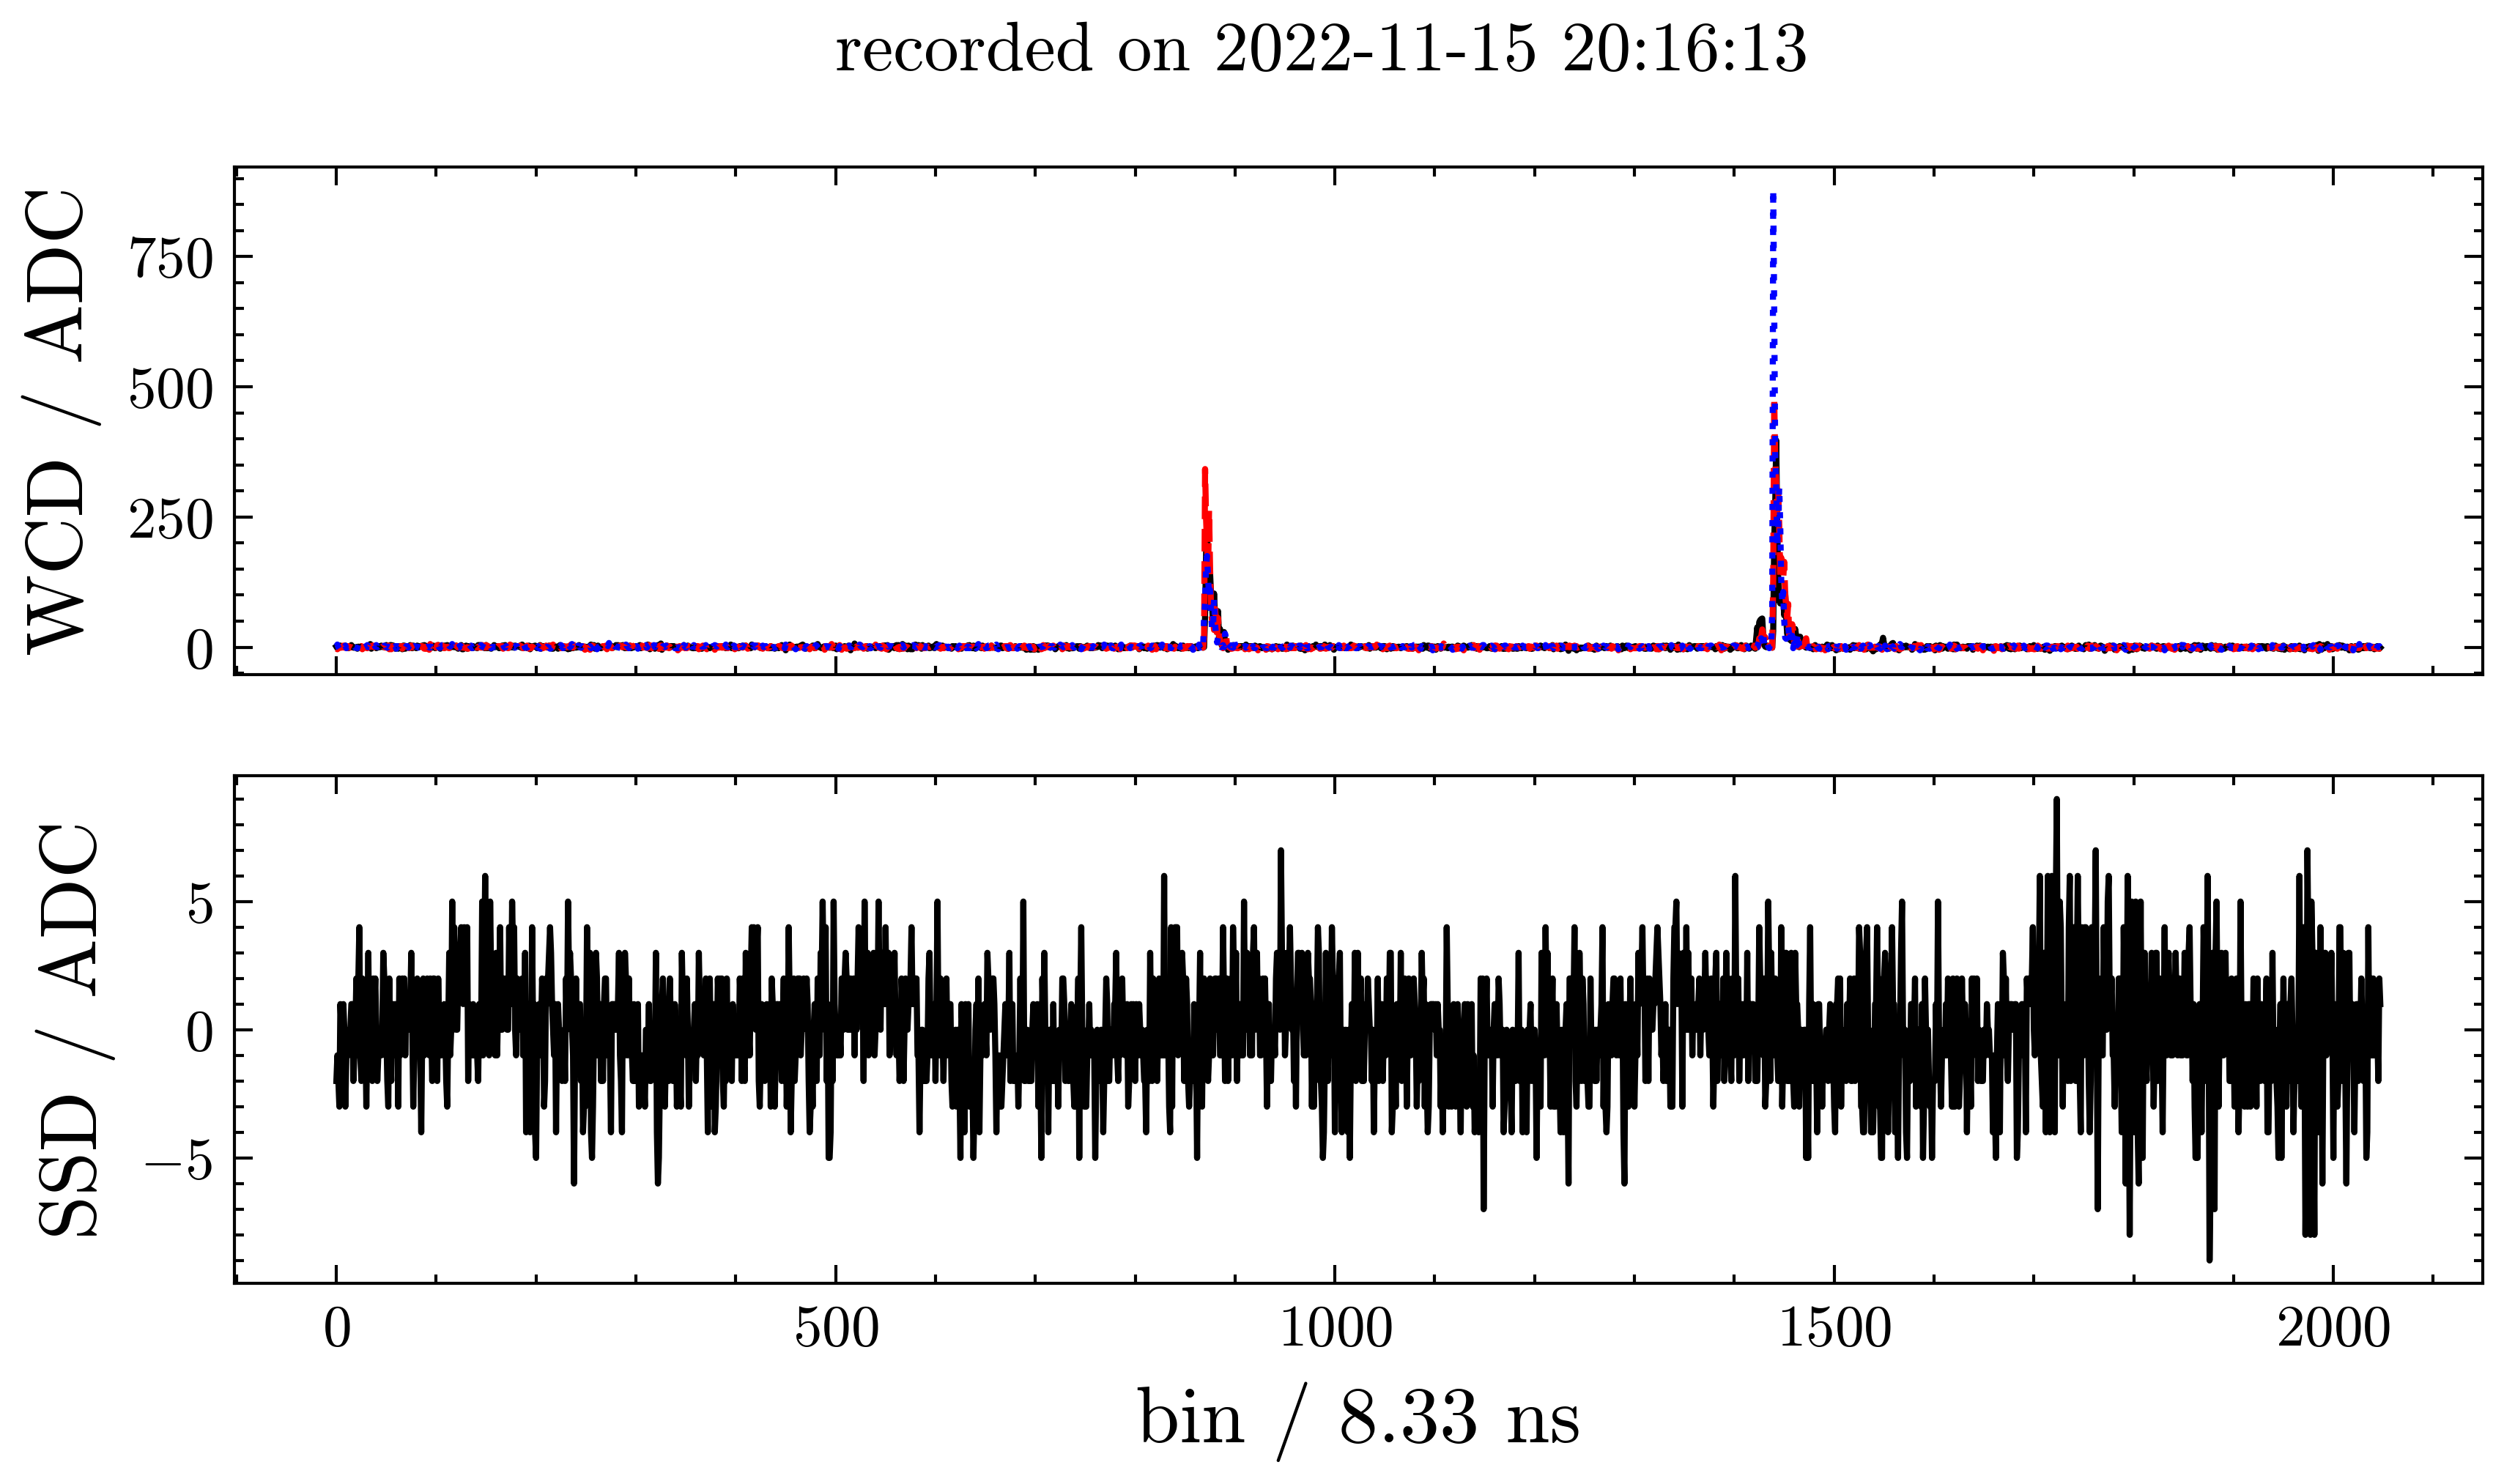

In [2]:
from datetime import datetime

wcd_fmt = np.dtype([('timestamp', 'I'), ('t1_latch_bin', 'h'), ('vem_peak', ('e', 3)), ('baseline', ('H', 3)), ('trace', ('h', (3, 2048)))])
ssd_fmt = np.dtype([('timestamp', 'I'), ('t1_latch_bin', 'h'), ('mip_peak', 'e'), ('baseline', 'H'), ('trace', ('h', 2048))])

wcd_data = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/temp.wcd', dtype=wcd_fmt)
ssd_data = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/temp.ssd', dtype=ssd_fmt)

first_t1_index = np.argmax(ssd_data['t1_latch_bin'] != -1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(range(2048), wcd_data[first_t1_index]['trace'][0])                 # 1st WCD PMT
ax1.plot(range(2048), wcd_data[first_t1_index]['trace'][1])                 # 2nd WCD PMT
ax1.plot(range(2048), wcd_data[first_t1_index]['trace'][2])                 # 3rd WCD PMT

ax2.plot(range(2048), ssd_data[first_t1_index]['trace'])                    # SSD PMT
fig.suptitle(f'recorded on {datetime.fromtimestamp(wcd_data[first_t1_index]["timestamp"])}')
ax1.set_ylabel('WCD / ADC')
ax2.set_xlabel('bin / 8.33 ns')
ax2.set_ylabel('SSD / ADC')

In [4]:
print(wcd_data['vem_peak'])

[[157.1 162.2 161.9]
 [157.1 162.2 161.9]
 [157.1 162.2 161.9]
 ...
 [157.1 162.2 161.9]
 [157.1 162.2 161.9]
 [157.1 162.2 161.9]]
